# Import packages and define data class

In [1]:
import numpy as np
import tensorflow as tf
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class WaveformData(object):
    def __init__(self, filename, anomaly_class, val_size):
        random.seed(42)
        f = open(filename,"r")
        data = f.read()
        lines = data.split('\n')

        self.data = []
        for line in lines[:-1]:
            self.data.append([float(x) for x in line.split(',')])
        self.val_size = val_size
        
        random.shuffle(self.data)
        self.anomaly_data = [x[:-1] for x in self.data if x[-1] == anomaly_class][:val_size]
        classes = [x[-1] for x in self.data if x[-1] != anomaly_class]
        self.data = [x[:-1] for x in self.data if x[-1] != anomaly_class]
        self.normal_val_data = self.data[:val_size]
        self.normal_classes = classes[:val_size]
        self.data = self.data[val_size:]
        self.classes = classes[val_size:]
        
    def normalize(self):
        # Normalize based on our training data
        self.mean, self.std = np.mean(self.data), np.std(self.data)
        self.data = (self.data - self.mean) / self.std
        self.normal_val_data = (self.normal_val_data - self.mean) / self.std
        self.anomaly_data = (self.anomaly_data - self.mean) / self.std

# Load data with 300 normal and anomalies in the validation, rest of the normals is the training

In [3]:
data = WaveformData('waveform.data', 2.0, 300)
data.normalize()

## Let's take a look at normal (red and blue) versus anomaly (green)

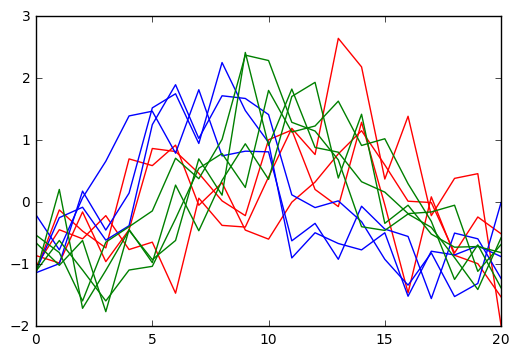

In [5]:
for i in range(6):
    if data.classes[i] == 0.:
        plt.plot(data.data[i], 'r')
    else:
        plt.plot(data.data[i], 'b')
for i in range(4):
    plt.plot(data.anomaly_data[i], 'g')

# AutoEncoder in TensorFlow

### Since our time series are of equal length (21 steps) we can use a normal autoencoder

First the encoder that takes a batch of examples and maps it to a low-dimensional space. In this case we have a fixed size input of 21 features. The input could be images, irregular length time series, other sequences as well, as long as we can define a reconstruction loss function that makes sense. We will use a mean squared error loss which assumes that all the time steps are of equal importance, we have no reason to believe otherwise.

In [6]:
class Encoder(object):
    def __init__(self, inp, n_features, n_hidden, repr_size):
        # inp is the placeholder for the input, n_features is the number of features our data has (21 in this example)
        # n_hidden is the size of the first hidden layer and n_hidden_2 is the dimensionality of the representation
        self.inp = inp
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.repr_size = repr_size
        self.W1 = tf.Variable(tf.random_normal([n_features, n_hidden], stddev=0.35))
        self.W2 = tf.Variable(tf.random_normal([n_hidden, repr_size], stddev=0.35))
        self.b1 = tf.Variable(tf.random_normal([n_hidden], stddev=0.35))
        self.b2 = tf.Variable(tf.random_normal([repr_size], stddev=0.35))
        
        self.layer_1 = tf.nn.tanh(tf.matmul(self.inp, self.W1) + self.b1)
        self.encoder_out = tf.matmul(self.layer_1, self.W2) + self.b2

The decoder will take the output of the encoder and transform it back into data of the same size as our input (in this case 21 features)

In [7]:
class Decoder(object):
    def __init__(self, inp, repr_size, n_hidden, n_features):
        self.inp = inp
        self.n_hidden = n_hidden
        self.W1 = tf.Variable(tf.random_normal([repr_size, n_hidden], stddev=0.35))
        self.W2 = tf.Variable(tf.random_normal([n_hidden, n_features], stddev=0.35))
        self.b1 = tf.Variable(tf.random_normal([n_hidden], stddev=0.35))
        self.b2 = tf.Variable(tf.random_normal([n_features], stddev=0.35))
        
        self.layer_1 = tf.nn.tanh(tf.matmul(self.inp, self.W1) + self.b1)
        self.decoder_out = tf.matmul(self.layer_1, self.W2) + self.b2

Now the full model which contains the encoder, the decoder and the loss function

In [8]:
class Autoencoder(object):
    def __init__(self, n_features, repr_size, n_hidden, batch_size=16):
        # n_features is the number of features our data has (21 in this example)
        # repr_size the dimensionality of our representation
        # n_hidden_1 is the size of the layers closest to the in and output
        # n_hidden_2 is the size of the layers closest to the embedding layer
        # batch_size number of samples to run per batch
        
        self.n_features = n_features
        self.repr_size = repr_size
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        
        # Start session, placeholder has None in shape for batches
        self.sess = tf.Session()
        self.inp = tf.placeholder(tf.float32, [None, n_features])
        
        # Make the encoder and the decoder
        self.encoder = Encoder(self.inp, n_features, n_hidden, repr_size)
        self.decoder = Decoder(self.encoder.encoder_out, repr_size, n_hidden, n_features)
        
        # Loss function mean squared error and AdamOptimizer
        self.loss = tf.reduce_mean(tf.square(self.decoder.decoder_out - self.inp), -1)
        self.mean_loss = tf.reduce_mean(self.loss)
        self.optimizer = tf.train.AdamOptimizer()
        self.train_op = self.optimizer.minimize(self.mean_loss)
        
        # Initialize all variables
        self.sess.run(tf.global_variables_initializer())
        
    def run_epoch(self, data_list):
        # Train once over the passed data_list and return the mean reconstruction loss after the epoch
        for index in range(len(data.data) // self.batch_size):
            self.sess.run(self.train_op, feed_dict={self.inp: data_list[index * self.batch_size : (index+1): self.batch_size]})
        return self.sess.run(self.mean_loss, feed_dict={self.inp: data_list})
    
    def representations(self, data_list):
        # Return a list of representations for the given list of time series
        return self.sess.run(self.encoder.encoder_out, feed_dict={self.inp: data_list})
    
    def reconstruction_errors(self, data_list):
        # Get mean squared reconstruction errors of passed data_list
        return self.sess.run(self.loss, feed_dict={self.inp: data_list})

## Let's start with a small representation, it already works reasonably well and allows for visualization of the representations

In [9]:
ae = Autoencoder(21, 2, 18)
for i in range(100):
    ae.run_epoch(data.data)

In [10]:
print(np.mean(ae.reconstruction_errors(data.data)))
ae.reconstruction_errors(data.data[:10])

0.971027


array([ 0.00735218,  1.60069513,  0.58655709,  0.73687392,  0.96212459,
        0.99841946,  1.24510932,  0.64570183,  0.73977351,  0.8212077 ], dtype=float32)

In [11]:
print(np.mean(ae.reconstruction_errors(data.normal_val_data)))
ae.reconstruction_errors(data.normal_val_data[:10])

0.95447


array([ 1.11412811,  0.63365555,  1.72316194,  1.17051768,  0.68073493,
        0.80367059,  0.86391705,  1.20197237,  0.94396663,  0.83959717], dtype=float32)

In [12]:
print(np.mean(ae.reconstruction_errors(data.anomaly_data)))
ae.reconstruction_errors(data.anomaly_data[:10])

1.14091


array([ 0.88395154,  0.92416418,  0.71333516,  1.03381371,  1.36057317,
        1.03473544,  1.03455353,  1.08316696,  0.97843182,  0.75589705], dtype=float32)

## The blue bars are the reconstruction errors of the normal validation data, the red ones are the anomalies, not very seperable but there is clearly signal

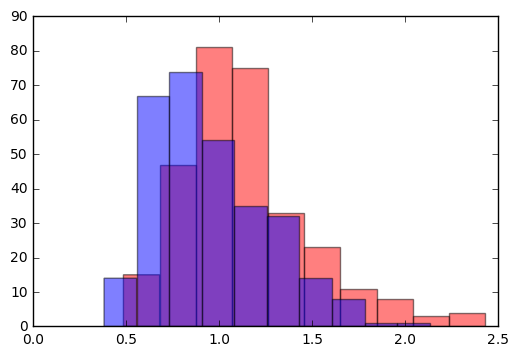

In [15]:
plt.hist(ae.reconstruction_errors(data.anomaly_data), alpha=0.5, color='r')
plt.hist(ae.reconstruction_errors(data.normal_val_data), alpha=0.5, color='b')
plt.show()

## The red dots are the learned representations of the anomalies while the blue ones are unseen normal examples

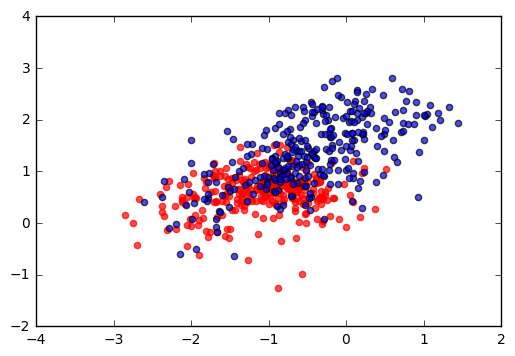

In [17]:
anomaly_repr = ae.representations(data.anomaly_data)
normal_repr = ae.representations(data.normal_val_data)
anom_x, anom_y = zip(*anomaly_repr)
norm_x, norm_y = zip(*normal_repr)
plt.scatter(anom_x, anom_y, color='red', alpha=0.7)
plt.scatter(norm_x, norm_y, alpha=0.7)

## Depending on the costs with regards to fixing/inspecting and the costs of not fixing/inspecting we can pick a value for which higher ones count as potential anomalies

This is similar to picking a seperator and we can plot a ROC curve to see how well we can seperate them

In [18]:
from sklearn.metrics import roc_curve, auc

anomaly_errors = ae.reconstruction_errors(data.anomaly_data)
normal_val_errors = ae.reconstruction_errors(data.normal_val_data)
roc_y = [1 for _ in range(len(anomaly_errors))] + [0 for _ in range(len(normal_val_errors))]
roc_score = np.concatenate([anomaly_errors, normal_val_errors])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(roc_y, roc_score)
roc_auc = auc(fpr, tpr)

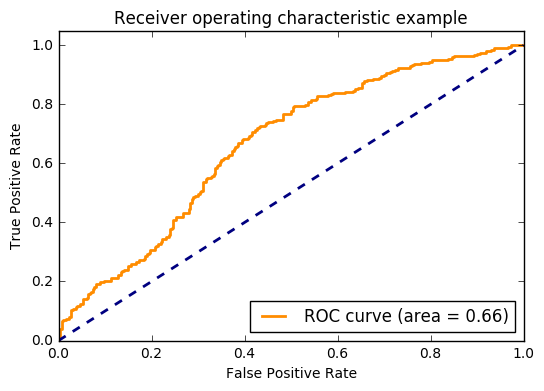

In [19]:
# Stolen from plot_roc sklearn example at http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()